### Collate FEA Results, Construct Final ABT (Dataset), Perform EDA (Data Understanding)
Analyses were run off in 50 'buckets' of 1,000 (load cases).  This was done to enable the analsyes to be run in parallel across several machines. Timetraces for 6 parameters were generated for each analysis. These timetraces were post-processed to get the max range for each parameter.  A summary dataframe for each bucket (1,000 files) is stored in the analysis results sub-folder.  We now need to combine the 50 separate dataframes to make a single results file.  This will then be joined with the analysis input dataset to form the final abt dataset.
- Concatenate each of the 50 result files
- Add new simulation time (simTime) feature to analysis parameters
- Investigate worst case load cases (for intuitive behaviour)
- Join analysis parameters to results to make dataset for modelling
- Perform EDA & review distribution of results

In [22]:
import os
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import ntpath # Equivalent of R's base (remove path)
import glob as gb
import seaborn as sns
from datetime import date

In [170]:
fo_p = '/Users/jasonpayne/Documents/my_repos/slug_spools/analysis_results/'
res_files = gb.glob(f'{fo_p}*.csv')

In [171]:
# Loop through each separate results (bucket) file and combine to one file
c = 1
for res_file in res_files:
    df = pd.read_csv(f'{res_file}')
    if c == 1:
        res_df = df
    else:    
        res_df = pd.concat([res_df, df], ignore_index=True)
    c += 1

In [172]:
# Sort by load case number and reset the index
res_df.sort_values(by=['load_case'], inplace=True)
res_df.reset_index(inplace=True, drop=True)

In [173]:
# Print a statistical summary of the result data
res_df.describe()

,out_oopDisp_mm_n2,out_supReac_kN_n3,out_supReac_kN_n4,out_verDisp_mm_n5,out_oopDisp_mm_n5,out_endBend_kNm_n6
count,49975.000000,49975.000000,49975.000000,49975.000000,49975.000000,49975.000000
mean,182.077874,15.741557,52.692365,233.540208,187.301203,218.388931
std,31.026056,1.884192,6.472451,42.935592,44.422666,59.079226
min,73.240000,8.530000,20.480000,93.420000,73.890000,83.330000
25%,162.600000,14.470000,48.770000,204.105000,160.960000,177.360000
50%,179.730000,15.510000,53.150000,228.650000,180.340000,209.190000
75%,198.140000,16.730000,56.950000,257.340000,203.755000,247.500000
max,497.920000,36.330000,89.490000,578.030000,711.910000,700.150000


In [5]:
# Utility function for creating basic data quality report for numeric data
def generate_dq_num(dat, cols):
    data_types = pd.DataFrame(dat.dtypes, columns=['Data Type'])
    missing_data = pd.DataFrame(dat.isnull().sum(), columns=['Missing Values'])
    unique_values = pd.DataFrame(columns=['Unique Values'])
    max_values = pd.DataFrame(columns=['Max Value'])
    min_values = pd.DataFrame(columns=['Min Value'])
    mean_values = pd.DataFrame(columns=['Mean Value'])
    median_values = pd.DataFrame(columns=['Median Value'])
    for row in list(cols.values):
        unique_values.loc[row] = [dat[row].nunique()]    
        min_values.loc[row] = [dat[row].min()]
        mean_values.loc[row] = [dat[row].mean()]
        median_values.loc[row] = [dat[row].median()]
        max_values.loc[row] = [dat[row].max()]    
    dq_report = data_types.join(missing_data).join(unique_values).join(min_values).\
        join(mean_values).join(median_values).join(max_values)
    return(dq_report)

In [175]:
# Print a standard data quality report
generate_dq_num(res_df.drop(['load_case'], axis=1), res_df.columns.drop(['load_case']))

,Data Type,Missing Values,Unique Values,Min Value,Mean Value,Median Value,Max Value
out_oopDisp_mm_n2,float64,0,12396,73.24,182.077874,179.73,497.92
out_supReac_kN_n3,float64,0,1355,8.53,15.741557,15.51,36.33
out_supReac_kN_n4,float64,0,3734,20.48,52.692365,53.15,89.49
out_verDisp_mm_n5,float64,0,16183,93.42,233.540208,228.65,578.03
out_oopDisp_mm_n5,float64,0,14657,73.89,187.301203,180.34,711.91
out_endBend_kNm_n6,float64,0,18986,83.33,218.388931,209.19,700.15


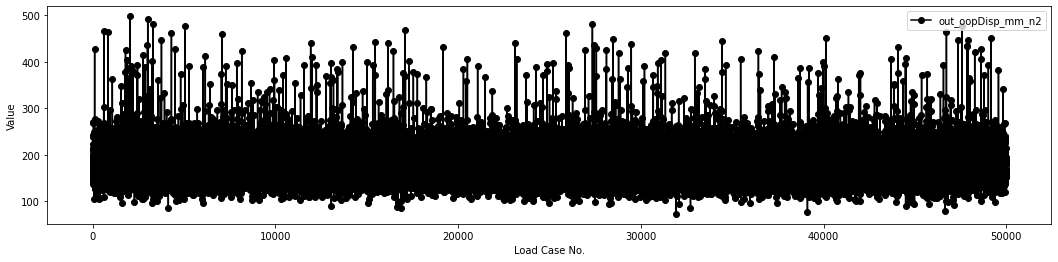

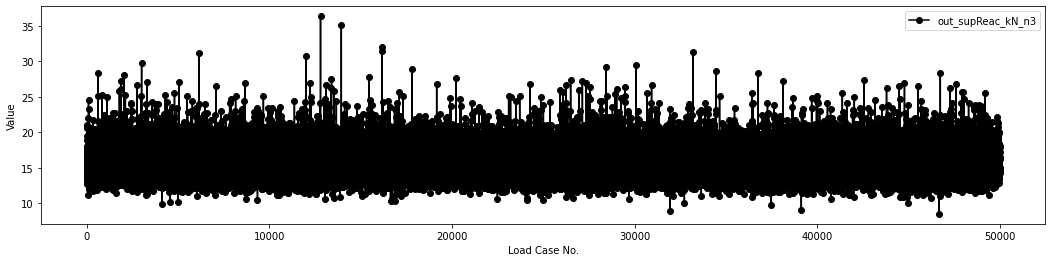

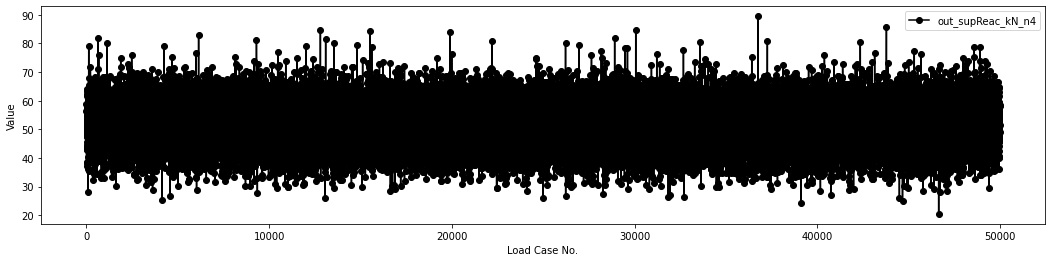

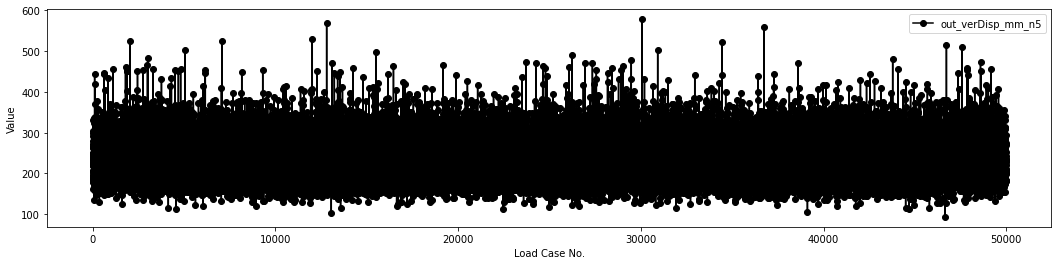

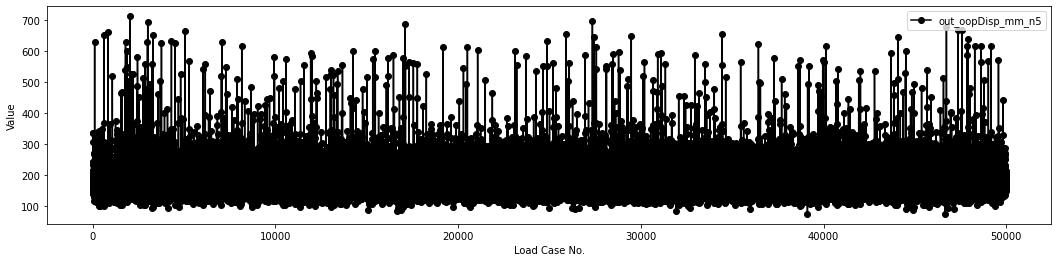

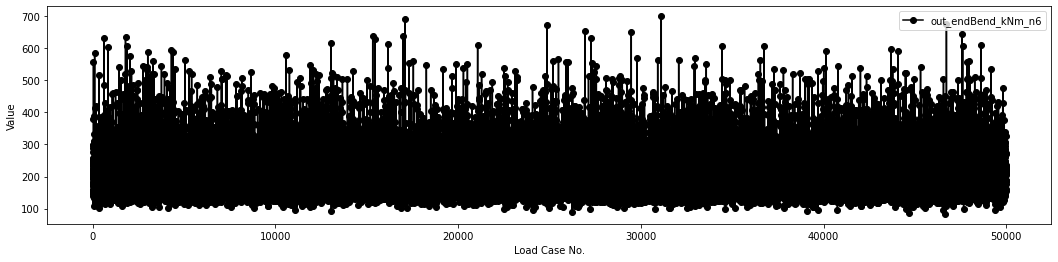

In [195]:
# Plot each result for each load case
for chan in res_df.columns[1:]:
    fig, ax = plt.subplots(figsize = (18, 4))
    ax.plot(res_df[chan], color = 'black', marker = 'o', zorder = 1, label = chan)
    ax.legend(loc = 'upper right')
    plt.xlabel('Load Case No.')
    plt.ylabel('Value')
plt.show()

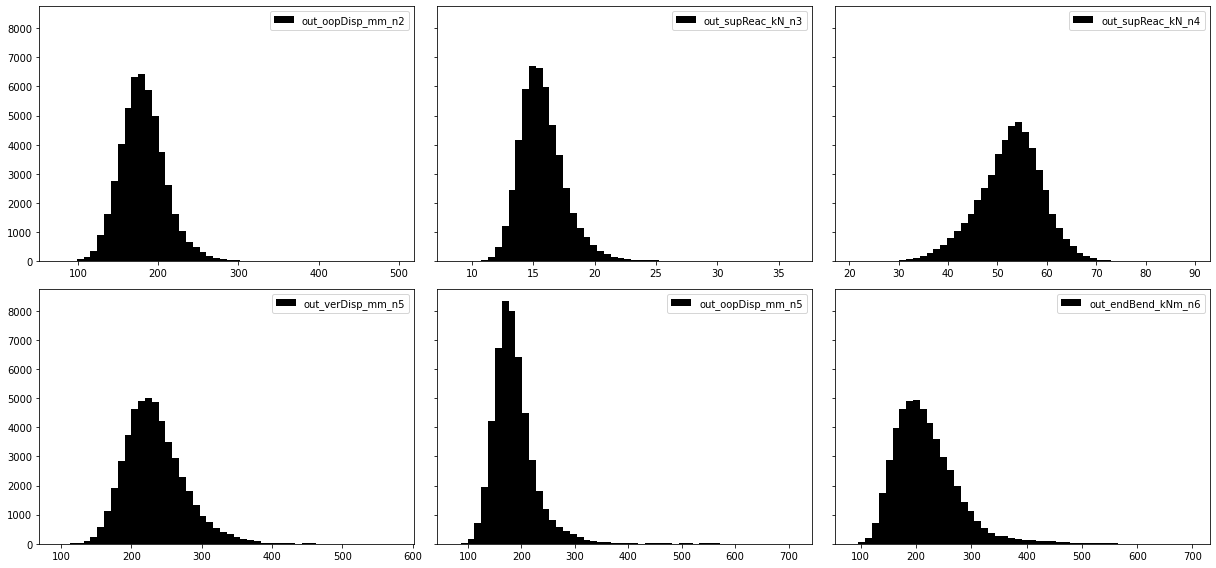

In [177]:
# Plot distributions of each result parameter
n_bins = 50
fig, axs = plt.subplots(2, 3, sharey=True, tight_layout=True, figsize = (17, 8))
axs = axs.ravel()
drops = ['load_case']
for p, ref in enumerate(res_df.columns.drop(drops)):
    axs[p].hist(res_df[ref].values, bins=n_bins, label = ref, color = 'black')
    axs[p].legend(loc = 'upper right')

In [178]:
# Read the analysis inputs file
abt_df = pd.read_csv('220304_abt.csv')

In [179]:
# Add simulation time as a feature (may be useful)
SLUG_COUNT = 12
abt_df['simTime'] = round(1 + SLUG_COUNT*(abt_df.slugLen/abt_df.slugVel + abt_df.pockLen/abt_df.slugVel) + (60/abt_df.slugVel), 1)
abt_df

,loadCase,slugDen,slugLen,pockDen,pockLen,slugVel,basePer,baseAmp,basePha,simTime
0,00001_sd786_sl6_pd234_pl10_sv6_bp13_ba850_bp74...,785.67,6.47,234.16,10.06,5.77,12.55,0.85,74.10,45.8
1,00002_sd705_sl10_pd190_pl11_sv7_bp12_ba800_bp5...,705.03,10.36,190.44,11.25,7.42,11.63,0.80,59.11,44.0
2,00003_sd742_sl12_pd159_pl13_sv7_bp12_ba650_bp6...,741.98,11.64,159.09,12.52,7.42,11.54,0.65,65.23,48.2
3,00004_sd732_sl9_pd168_pl10_sv10_bp11_ba670_bp6...,731.88,8.82,167.88,9.84,9.52,11.48,0.67,67.85,30.8
4,00005_sd669_sl11_pd214_pl9_sv8_bp13_ba810_bp57...,669.21,11.46,213.87,8.56,8.18,12.86,0.81,56.68,37.7
...,...,...,...,...,...,...,...,...,...,...
49995,49996_sd732_sl9_pd173_pl10_sv9_bp13_ba620_bp59...,732.32,9.06,172.68,9.95,8.89,12.78,0.62,59.34,33.4
49996,49997_sd793_sl11_pd189_pl10_sv7_bp11_ba660_bp8...,793.21,11.41,189.05,10.24,7.15,10.96,0.66,80.89,45.7
49997,49998_sd621_sl12_pd173_pl9_sv4_bp12_ba720_bp65...,620.52,11.60,173.32,9.37,4.03,12.21,0.72,65.25,78.3
49998,49999_sd704_sl8_pd214_pl12_sv11_bp10_ba640_bp6...,704.16,8.17,214.00,11.90,11.39,9.95,0.64,65.80,27.4


In [180]:
# Change the name of the load case field so that it is consitent between files
# and we can use a left join (on load case)
res_df = res_df.rename(columns={"load_case":"loadCase"})

In [181]:
# Remove the file extension from the abt file
# Again for consistency between files
abt_df.loadCase = abt_df.loadCase.apply(lambda x: x[:len(x) - 6])

In [182]:
# Perform left join to complete the final dataset
dataset = abt_df.merge(res_df, on='loadCase', how='left')
dataset

,loadCase,slugDen,slugLen,pockDen,pockLen,slugVel,basePer,baseAmp,basePha,simTime,out_oopDisp_mm_n2,out_supReac_kN_n3,out_supReac_kN_n4,out_verDisp_mm_n5,out_oopDisp_mm_n5,out_endBend_kNm_n6
0,00001_sd786_sl6_pd234_pl10_sv6_bp13_ba850_bp74,785.67,6.47,234.16,10.06,5.77,12.55,0.85,74.10,45.8,197.45,16.22,56.42,248.24,180.47,198.49
1,00002_sd705_sl10_pd190_pl11_sv7_bp12_ba800_bp59,705.03,10.36,190.44,11.25,7.42,11.63,0.80,59.11,44.0,186.85,15.97,58.86,262.33,178.72,238.07
2,00003_sd742_sl12_pd159_pl13_sv7_bp12_ba650_bp65,741.98,11.64,159.09,12.52,7.42,11.54,0.65,65.23,48.2,155.47,14.29,48.63,220.89,163.53,180.64
3,00004_sd732_sl9_pd168_pl10_sv10_bp11_ba670_bp68,731.88,8.82,167.88,9.84,9.52,11.48,0.67,67.85,30.8,169.47,15.18,48.72,188.47,163.76,233.31
4,00005_sd669_sl11_pd214_pl9_sv8_bp13_ba810_bp57,669.21,11.46,213.87,8.56,8.18,12.86,0.81,56.68,37.7,223.64,16.90,58.51,271.74,242.37,219.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49996_sd732_sl9_pd173_pl10_sv9_bp13_ba620_bp59,732.32,9.06,172.68,9.95,8.89,12.78,0.62,59.34,33.4,153.57,14.56,47.50,180.32,163.53,212.53
49996,49997_sd793_sl11_pd189_pl10_sv7_bp11_ba660_bp81,793.21,11.41,189.05,10.24,7.15,10.96,0.66,80.89,45.7,159.56,14.68,51.68,210.52,157.05,186.71
49997,49998_sd621_sl12_pd173_pl9_sv4_bp12_ba720_bp65,620.52,11.60,173.32,9.37,4.03,12.21,0.72,65.25,78.3,168.38,14.32,49.23,207.34,149.16,155.59
49998,49999_sd704_sl8_pd214_pl12_sv11_bp10_ba640_bp66,704.16,8.17,214.00,11.90,11.39,9.95,0.64,65.80,27.4,169.73,17.99,58.00,274.30,178.30,325.06


In [183]:
# Verify some of the larger simulation times
# Get load case number & review the FEA animation
dataset.simTime[dataset.simTime > 250]

1748     339.7
2757     357.7
3716     346.0
10260    652.0
14276    251.2
17322    253.9
18619    285.7
19718    253.9
24605    279.8
24857    884.8
24936    273.9
26446    408.4
29144    492.4
41168    330.4
42507    324.2
43407    258.7
Name: simTime, dtype: float64

Check of load case 24,856 confirms very long (outlier) simulation time due to very slow (0-1m/s) slug velocity.

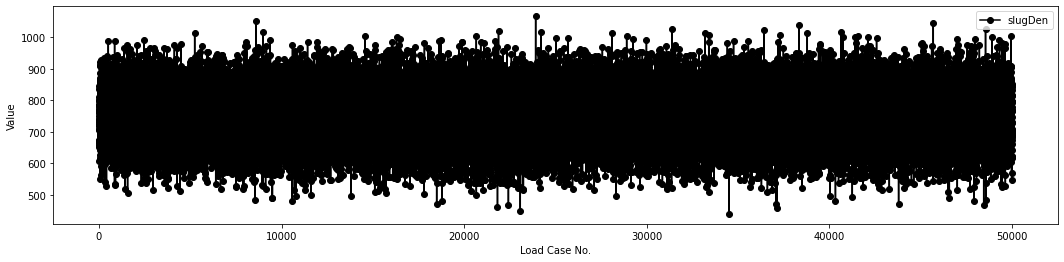

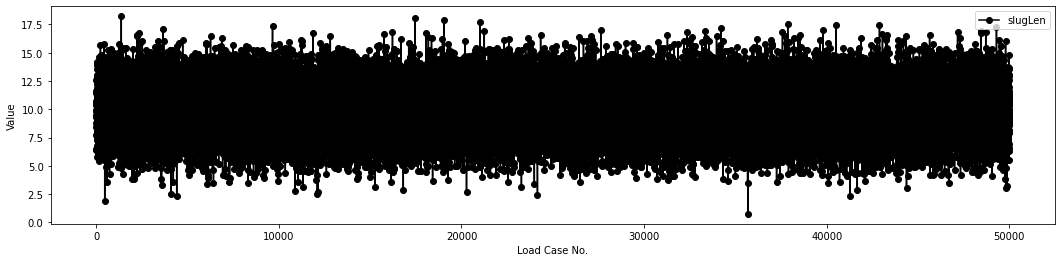

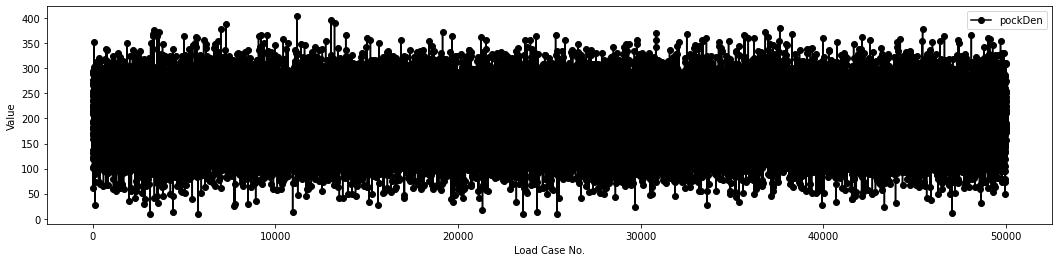

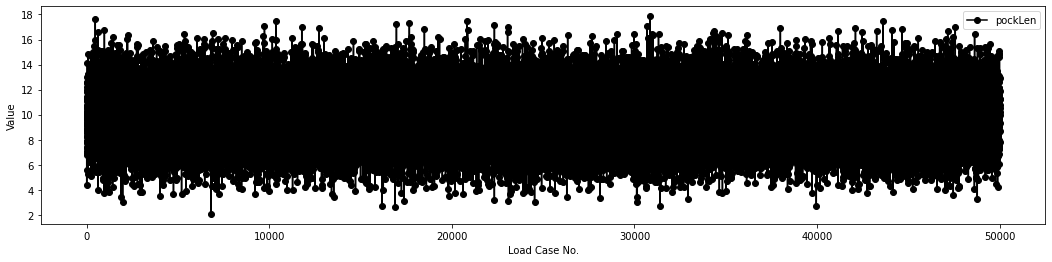

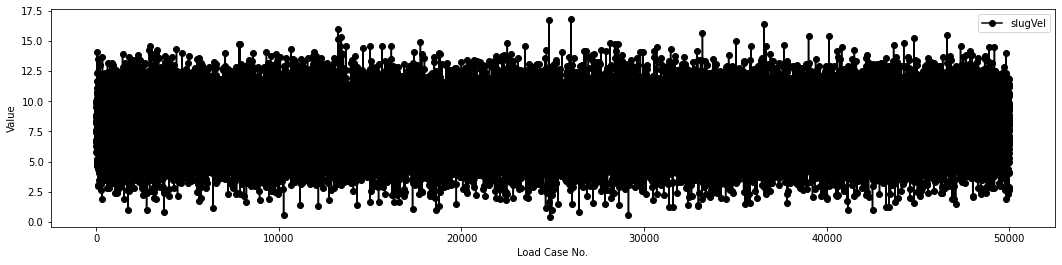

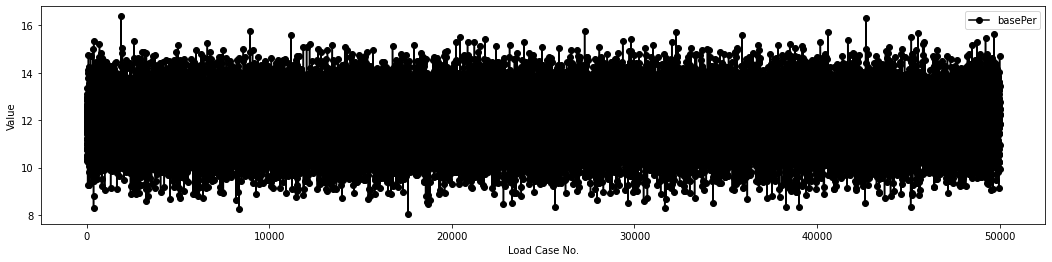

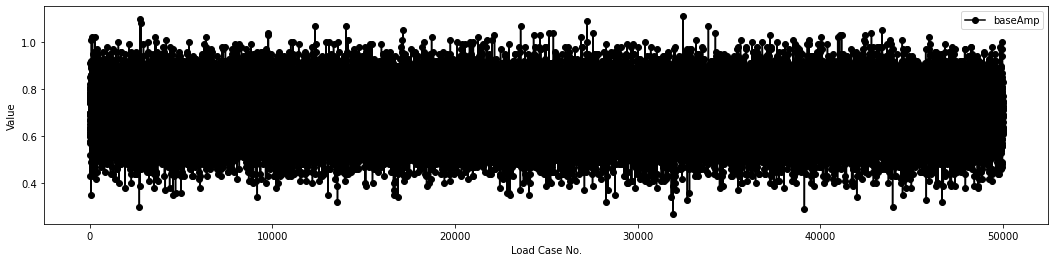

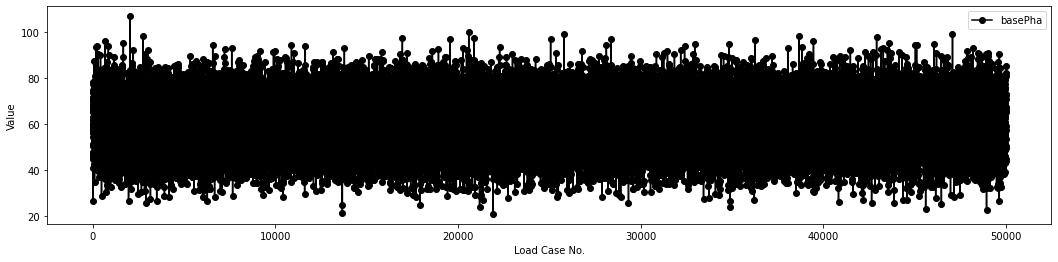

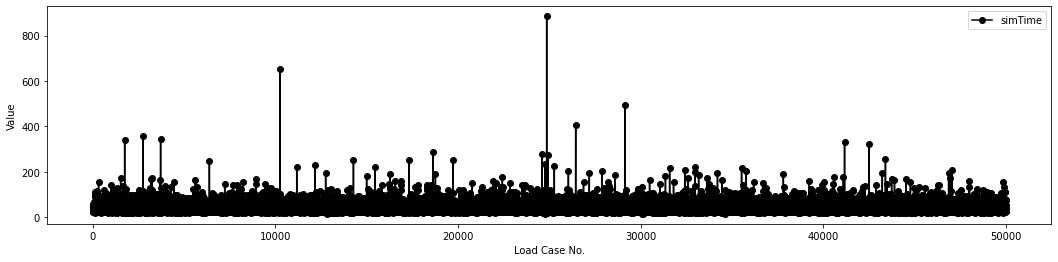

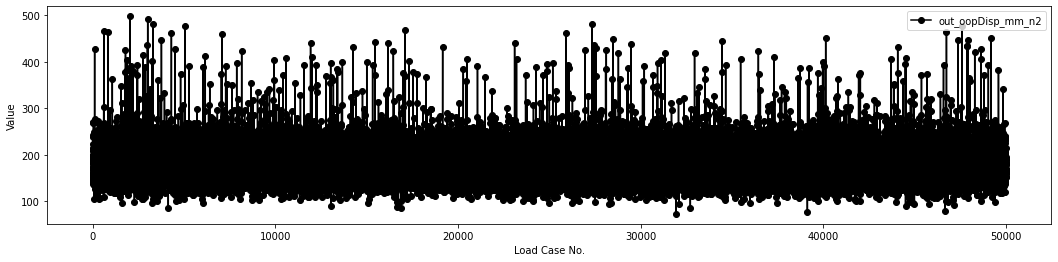

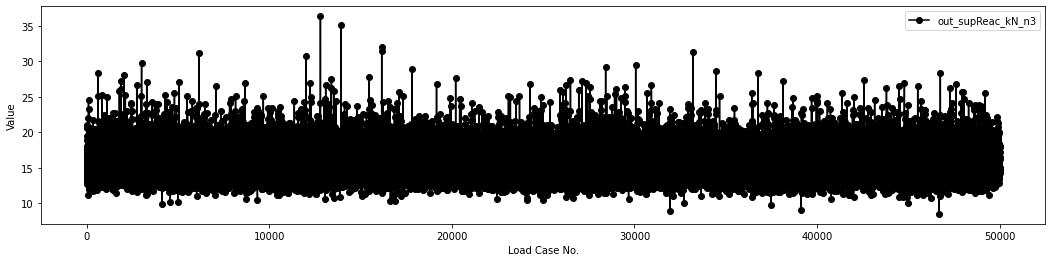

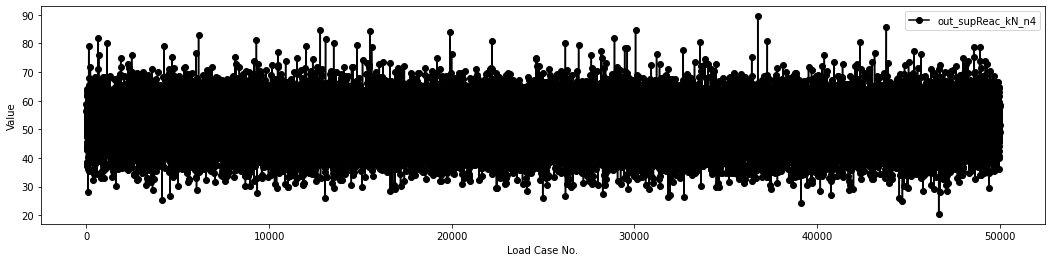

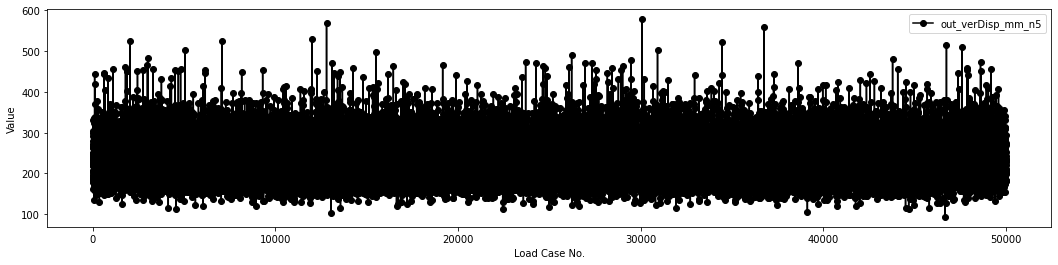

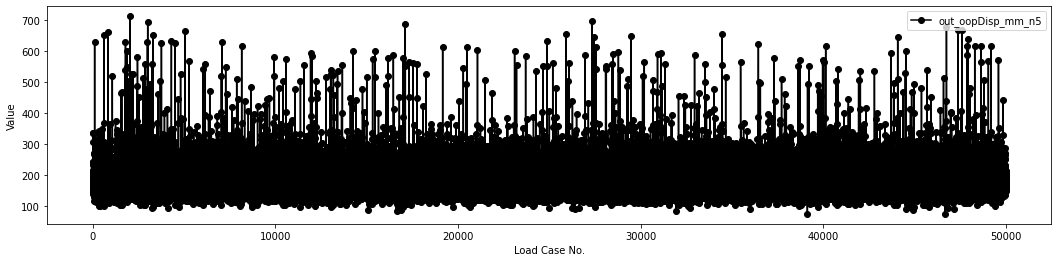

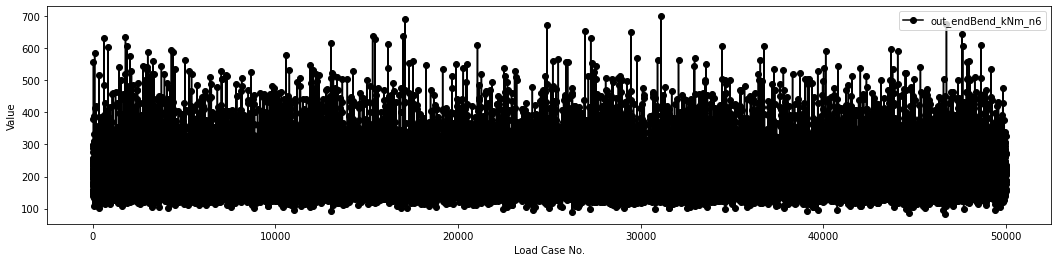

In [194]:
# Plot each column for each load case
for chan in dataset.columns[1:]:
    fig, ax = plt.subplots(figsize = (18, 4))
    ax.plot(dataset[chan], color = 'black', marker = 'o', zorder = 1, label = chan)
    ax.legend(loc = 'upper right')
    plt.xlabel('Load Case No.')
    plt.ylabel('Value')
plt.show()

### Inspect & Verify FEA Extreme Results
Examine some of the most damaging load cases & confirm results are intuitively correct

#### 1) Maximum Out-of-place Displacement at Node 2

In [192]:
# Examine load case with max oop displacement at node 2
dataset[dataset.out_oopDisp_mm_n2 == dataset.out_oopDisp_mm_n2.max()]

,loadCase,slugDen,slugLen,pockDen,pockLen,slugVel,basePer,baseAmp,basePha,simTime,out_oopDisp_mm_n2,out_supReac_kN_n3,out_supReac_kN_n4,out_verDisp_mm_n5,out_oopDisp_mm_n5,out_endBend_kNm_n6
2053,02054_sd801_sl7_pd135_pl9_sv13_bp12_ba780_bp107,801.05,7.22,135.4,8.53,13.39,11.69,0.78,106.85,19.6,497.92,28.13,68.79,524.62,711.91,576.99


Large delta density (801 kg/m3 vs 135 kg/m3) and high slug velocity (13.4 m/s).  

#### 2) Maximum Vertical Displacement at Node 5

In [190]:
# Examine load case with max vertical displacement ast node 5
dataset[dataset.out_verDisp_mm_n5 == dataset.out_verDisp_mm_n5.max()]

,loadCase,slugDen,slugLen,pockDen,pockLen,slugVel,basePer,baseAmp,basePha,simTime,out_oopDisp_mm_n2,out_supReac_kN_n3,out_supReac_kN_n4,out_verDisp_mm_n5,out_oopDisp_mm_n5,out_endBend_kNm_n6
30066,30067_sd783_sl8_pd214_pl4_sv13_bp11_ba570_bp64,782.84,7.52,214.48,4.49,12.74,11.19,0.57,63.73,17.0,202.28,29.44,84.55,578.03,250.79,425.94


Relatively high delta density (782 kg/m3 vs 214 kg/m3) and high slug velocity (12.8 m/s).  Slug length 7.5 m and (short) pocket length of 4.5 m perhaps exciting the vertical displacement.    

#### 3) Maximum Out-of-place Displacement at Node 5

In [191]:
# Examine load case with max oop displacement at node 5
dataset[dataset.out_oopDisp_mm_n5 == dataset.out_oopDisp_mm_n5.max()]

,loadCase,slugDen,slugLen,pockDen,pockLen,slugVel,basePer,baseAmp,basePha,simTime,out_oopDisp_mm_n2,out_supReac_kN_n3,out_supReac_kN_n4,out_verDisp_mm_n5,out_oopDisp_mm_n5,out_endBend_kNm_n6
2053,02054_sd801_sl7_pd135_pl9_sv13_bp12_ba780_bp107,801.05,7.22,135.4,8.53,13.39,11.69,0.78,106.85,19.6,497.92,28.13,68.79,524.62,711.91,576.99


Large delta density (801 kg/m3 vs 135 kg/m3) and high slug velocity (13.4 m/s).  

#### 4) Maximum Bending Moment Range at Node 6

In [193]:
# Examine load case with max bending moment range at node 6
dataset[dataset.out_endBend_kNm_n6 == dataset.out_endBend_kNm_n6.max()]

,loadCase,slugDen,slugLen,pockDen,pockLen,slugVel,basePer,baseAmp,basePha,simTime,out_oopDisp_mm_n2,out_supReac_kN_n3,out_supReac_kN_n4,out_verDisp_mm_n5,out_oopDisp_mm_n5,out_endBend_kNm_n6
31123,31124_sd770_sl11_pd229_pl5_sv13_bp14_ba680_bp64,769.7,11.11,228.82,4.62,12.67,13.95,0.68,63.78,20.6,404.77,23.26,67.16,396.66,593.84,700.15


Relatively high delta density (770 kg/m3 vs 229 kg/m3) and high slug velocity (12.7 m/s).  Slug length 11.1 m and (short) pocket length of 4.6 m perhaps exciting the bending moment range.  

### Save Dataset

In [188]:
# Write the dataset as a csv
dataset.to_csv(f'{date.today().strftime("%y%m%d")}_slugs_dataset.csv', index=False)

## Data Understanding

In [50]:
# Print the dataset
df_all = pd.read_csv('220306_slugs_dataset.csv')
df_all

,loadCase,slugDen,slugLen,pockDen,pockLen,slugVel,basePer,baseAmp,basePha,simTime,out_oopDisp_mm_n2,out_supReac_kN_n3,out_supReac_kN_n4,out_verDisp_mm_n5,out_oopDisp_mm_n5,out_endBend_kNm_n6
0,00001_sd786_sl6_pd234_pl10_sv6_bp13_ba850_bp74,785.67,6.47,234.16,10.06,5.77,12.55,0.85,74.10,45.8,197.45,16.22,56.42,248.24,180.47,198.49
1,00002_sd705_sl10_pd190_pl11_sv7_bp12_ba800_bp59,705.03,10.36,190.44,11.25,7.42,11.63,0.80,59.11,44.0,186.85,15.97,58.86,262.33,178.72,238.07
2,00003_sd742_sl12_pd159_pl13_sv7_bp12_ba650_bp65,741.98,11.64,159.09,12.52,7.42,11.54,0.65,65.23,48.2,155.47,14.29,48.63,220.89,163.53,180.64
3,00004_sd732_sl9_pd168_pl10_sv10_bp11_ba670_bp68,731.88,8.82,167.88,9.84,9.52,11.48,0.67,67.85,30.8,169.47,15.18,48.72,188.47,163.76,233.31
4,00005_sd669_sl11_pd214_pl9_sv8_bp13_ba810_bp57,669.21,11.46,213.87,8.56,8.18,12.86,0.81,56.68,37.7,223.64,16.90,58.51,271.74,242.37,219.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49996_sd732_sl9_pd173_pl10_sv9_bp13_ba620_bp59,732.32,9.06,172.68,9.95,8.89,12.78,0.62,59.34,33.4,153.57,14.56,47.50,180.32,163.53,212.53
49996,49997_sd793_sl11_pd189_pl10_sv7_bp11_ba660_bp81,793.21,11.41,189.05,10.24,7.15,10.96,0.66,80.89,45.7,159.56,14.68,51.68,210.52,157.05,186.71
49997,49998_sd621_sl12_pd173_pl9_sv4_bp12_ba720_bp65,620.52,11.60,173.32,9.37,4.03,12.21,0.72,65.25,78.3,168.38,14.32,49.23,207.34,149.16,155.59
49998,49999_sd704_sl8_pd214_pl12_sv11_bp10_ba640_bp66,704.16,8.17,214.00,11.90,11.39,9.95,0.64,65.80,27.4,169.73,17.99,58.00,274.30,178.30,325.06


In [8]:
# Print the data quality report
generate_dq_num(df_all.drop(['loadCase'], axis=1), df_all.columns.drop(['loadCase']))

,Data Type,Missing Values,Unique Values,Min Value,Mean Value,Median Value,Max Value
slugDen,float64,0,23921,439.01,749.872761,749.20,1066.90
slugLen,float64,0,1273,0.75,10.000962,10.01,18.22
pockDen,float64,0,18650,9.47,199.758501,199.69,404.01
pockLen,float64,0,1274,2.07,10.010496,10.01,17.86
slugVel,float64,0,1284,0.40,7.993627,7.99,16.81
basePer,float64,0,677,8.05,11.999761,12.00,16.38
baseAmp,float64,0,82,0.27,0.699835,0.70,1.11
basePha,float64,0,5279,20.91,60.026022,59.97,106.85
simTime,float64,0,1071,15.20,41.570900,38.50,884.80
out_oopDisp_mm_n2,float64,25,12396,73.24,182.077874,179.73,497.92


In [12]:
# Identify the missing load cases for investigation
df_all.loc[df_all['out_oopDisp_mm_n2'].isnull(),]

,loadCase,slugDen,slugLen,pockDen,pockLen,slugVel,basePer,baseAmp,basePha,simTime,out_oopDisp_mm_n2,out_supReac_kN_n3,out_supReac_kN_n4,out_verDisp_mm_n5,out_oopDisp_mm_n5,out_endBend_kNm_n6
5743,05744_sd807_sl11_pd164_pl10_sv7_bp11_ba710_bp48,806.86,11.10,163.75,10.44,7.38,11.17,0.71,48.41,44.2,NaN,NaN,NaN,NaN,NaN,NaN
13396,13397_sd754_sl11_pd188_pl8_sv8_bp12_ba580_bp46,753.66,10.86,187.74,7.57,8.35,11.87,0.58,46.45,34.7,NaN,NaN,NaN,NaN,NaN,NaN
23997,23998_sd802_sl11_pd133_pl11_sv10_bp12_ba860_bp52,801.63,10.75,132.91,11.07,9.75,12.42,0.86,51.92,34.0,NaN,NaN,NaN,NaN,NaN,NaN
24842,24843_sd665_sl11_pd269_pl11_sv7_bp13_ba660_bp56,664.51,10.58,269.07,10.81,6.73,13.39,0.66,56.02,48.1,NaN,NaN,NaN,NaN,NaN,NaN
26522,26523_sd653_sl12_pd275_pl7_sv5_bp12_ba650_bp64,652.80,12.15,275.12,6.57,4.54,11.94,0.65,64.41,63.7,NaN,NaN,NaN,NaN,NaN,NaN
30207,30208_sd654_sl11_pd163_pl12_sv5_bp12_ba800_bp54,653.56,11.37,162.72,12.28,5.14,11.85,0.80,54.35,67.9,NaN,NaN,NaN,NaN,NaN,NaN
30427,30428_sd729_sl10_pd173_pl10_sv3_bp12_ba830_bp60,729.12,9.71,173.20,9.71,2.92,12.11,0.83,59.79,101.4,NaN,NaN,NaN,NaN,NaN,NaN
33777,33778_sd732_sl13_pd121_pl9_sv7_bp12_ba660_bp60,732.35,12.53,121.15,9.04,6.97,12.04,0.66,60.30,46.7,NaN,NaN,NaN,NaN,NaN,NaN
33778,33779_sd738_sl14_pd138_pl8_sv10_bp13_ba640_bp82,737.78,14.14,138.09,8.45,9.61,13.24,0.64,81.66,35.5,NaN,NaN,NaN,NaN,NaN,NaN
33779,33780_sd768_sl11_pd185_pl12_sv9_bp13_ba660_bp55,767.70,10.56,185.12,11.58,9.01,12.70,0.66,54.56,37.1,NaN,NaN,NaN,NaN,NaN,NaN


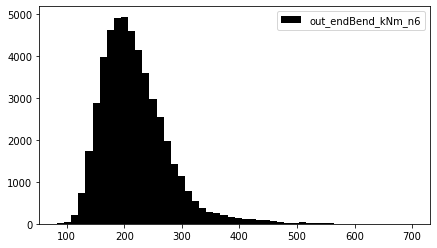

In [19]:
# Plot distribution of out_endBend_kNm_n6 (for the example in report)
n_bins = 50
fig, axs = plt.subplots(figsize = (7, 4))
drops = ['load_case']
axs.hist(df_all['out_endBend_kNm_n6'].values, bins=n_bins, label = 'out_endBend_kNm_n6', color = 'black')
axs.legend(loc = 'upper right')
plt.show()

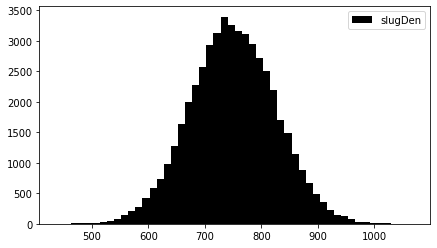

In [51]:
# Plot distribution of slug density (for the example in report)
# Should be normally distributed
n_bins = 50
fig, axs = plt.subplots(figsize = (7, 4))
drops = ['load_case']
axs.hist(df_all['slugDen'].values, bins=n_bins, label = 'slugDen', color = 'black')
axs.legend(loc = 'upper right')
plt.show()

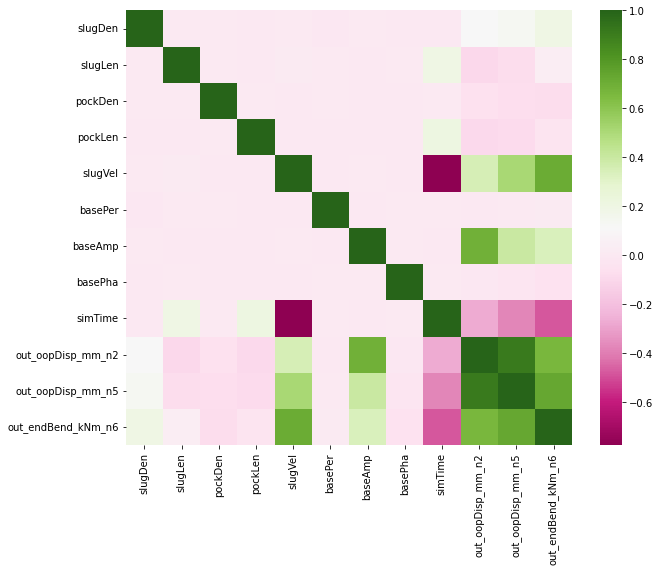

In [48]:
# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8))
dataplot = sns.heatmap(df_all.drop(['out_supReac_kN_n3', 'out_supReac_kN_n4', 'out_verDisp_mm_n5'], axis=1).corr(method='pearson'), cmap="PiYG")
plt.show()

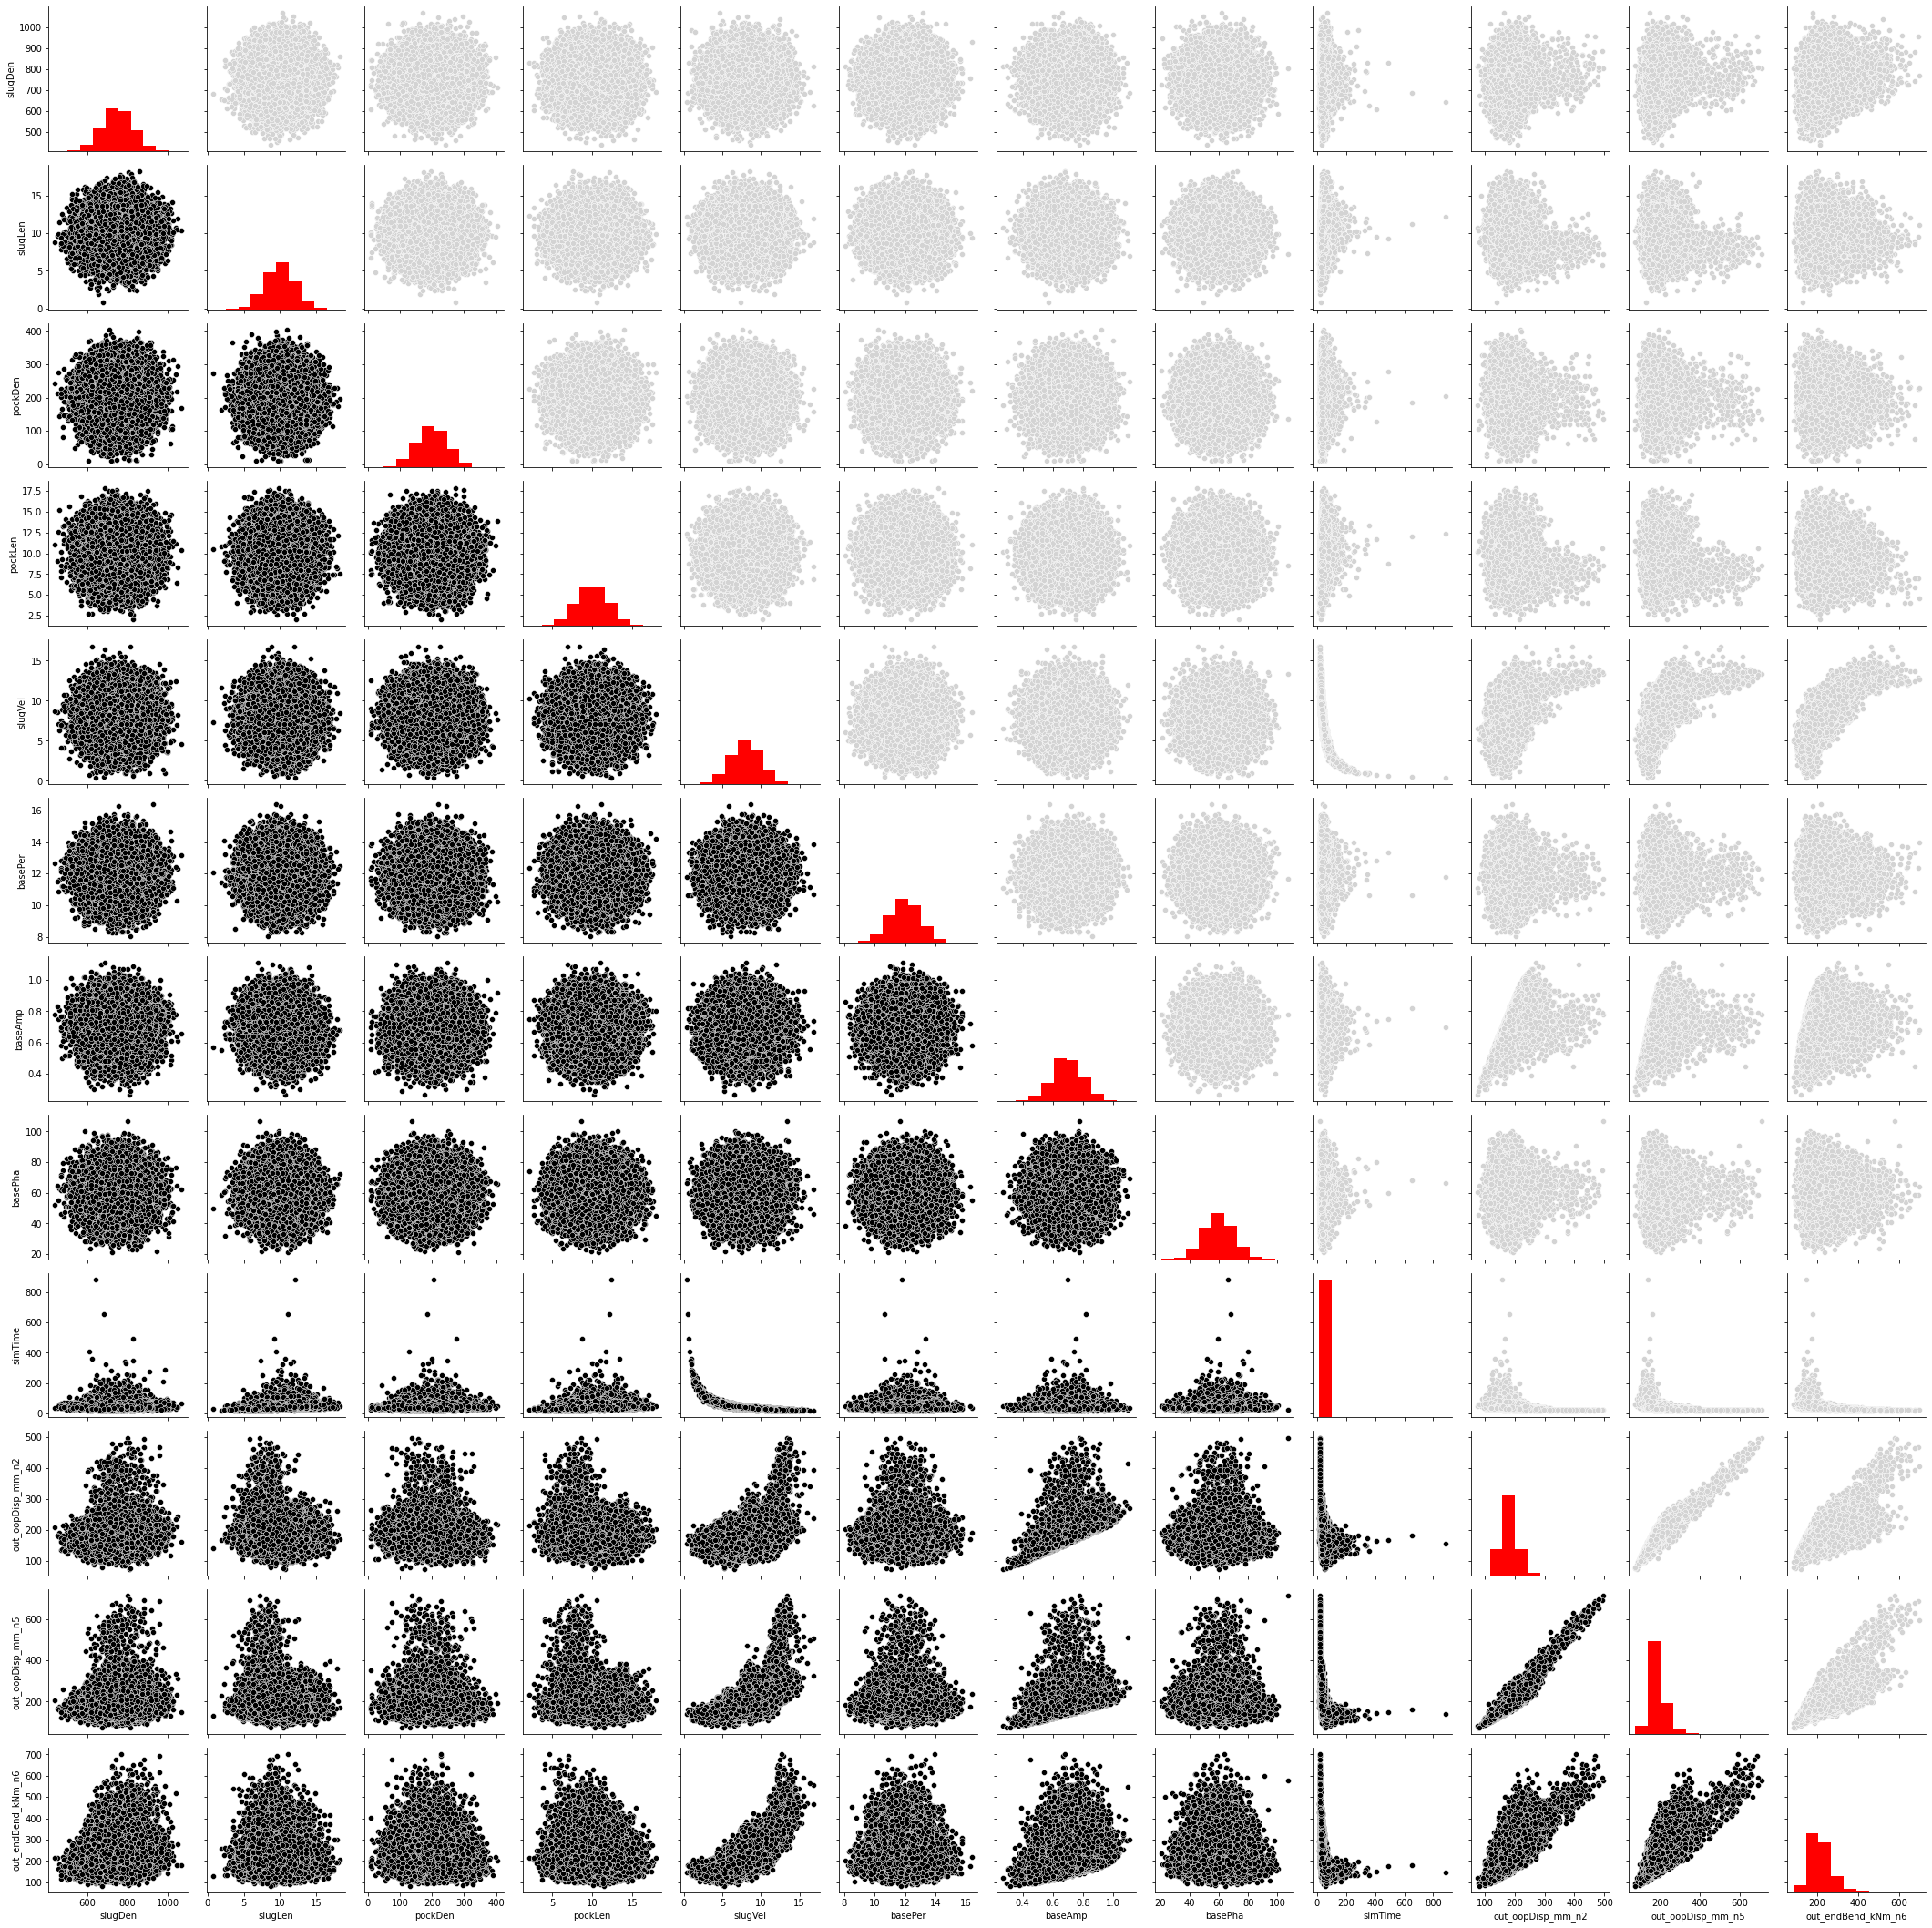

In [49]:
# Pair plots (scatter plot matrix)
g = sns.PairGrid(df_all.drop(['out_supReac_kN_n3', 'out_supReac_kN_n4', 'out_verDisp_mm_n5'], axis=1))
g.map_upper(sns.scatterplot, color='lightgrey')
g.map_lower(sns.scatterplot, color='black')
g.map_diag(plt.hist, color='red')

In [47]:
# Let's plot a table for a selection of closely correlated features
#df_add = df_all.copy(deep = True)
#df_add['densDiff'] = df_add['slugDen'] - df_add['pockDen']
df_all.drop(['out_supReac_kN_n3', 'out_supReac_kN_n4', 'out_verDisp_mm_n5'], axis=1).corr(method='pearson', min_periods=1).round(2)
#df_all.corr(method='pearson', min_periods=1).round(2)
#df_add.corr(method='pearson', min_periods=1).round(2)

,slugDen,slugLen,pockDen,pockLen,slugVel,basePer,baseAmp,basePha,simTime,out_oopDisp_mm_n2,out_oopDisp_mm_n5,out_endBend_kNm_n6
slugDen,1.00,0.00,0.00,-0.00,0.00,-0.01,0.00,0.00,-0.01,0.11,0.14,0.20
slugLen,0.00,1.00,0.00,-0.00,0.01,0.00,0.00,0.01,0.20,-0.10,-0.08,0.04
pockDen,0.00,0.00,1.00,0.01,-0.00,0.00,-0.00,0.00,0.00,-0.06,-0.07,-0.08
pockLen,-0.00,-0.00,0.01,1.00,-0.00,-0.00,0.00,-0.00,0.21,-0.09,-0.08,-0.04
slugVel,0.00,0.01,-0.00,-0.00,1.00,-0.00,0.00,-0.00,-0.78,0.35,0.51,0.71
basePer,-0.01,0.00,0.00,-0.00,-0.00,1.00,0.00,0.01,0.00,-0.00,0.00,0.01
baseAmp,0.00,0.00,-0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.69,0.40,0.33
basePha,0.00,0.01,0.00,-0.00,-0.00,0.01,0.00,1.00,0.01,-0.01,-0.03,-0.05
simTime,-0.01,0.20,0.00,0.21,-0.78,0.00,0.00,0.01,1.00,-0.27,-0.38,-0.48
out_oopDisp_mm_n2,0.11,-0.10,-0.06,-0.09,0.35,-0.00,0.69,-0.01,-0.27,1.00,0.91,0.66
